# Dependency

In [ ]:
!pip install git+https://github.com/davidbau/baukit
!pip install accelerate
!pip install einops

In [1]:
import os
import json
import pickle
import random
import warnings
import gc

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import transformers
from einops import rearrange
from IPython.display import display, HTML
from scipy.stats import spearmanr
from sklearn.linear_model import Ridge, RidgeClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.neural_network import MLPRegressor
from tqdm.auto import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer

from baukit import Trace, TraceDict
from custom_llama import llama # modified code to access attention head outputs

warnings.filterwarnings("ignore")

In [2]:
HUGGINGFACE_TOKEN = os.environ.get("HF_ACCESS_TOKEN")

# Preprocessing Data

In [3]:
df = pd.read_csv('./data_replication/HS116_members.csv')
df = df.loc[pd.notnull(df.nominate_dim1)].reset_index(drop=True)
df['first_middle_name'] = df['bioname'].apply(lambda x: x.split(', ')[1])
df['first_name'] = df['first_middle_name'].apply(lambda x: x.split(' ')[0] + ' ' if ' ' in x else x + ' ')
df['middle_name'] = df['first_middle_name'].apply(lambda x: x.split(' ')[1][0] + '. ' if ' ' in x else '')
df['last_name'] = df['bioname'].apply(lambda x: x.split(', ')[0].lower().capitalize().strip())
df['fullname'] = df['first_name'] + df['middle_name'] + df['last_name']

In [4]:
adfontesmedia = pd.read_csv('./data_replication/adfontesmedia.csv')

# Probing Partisan Slant

## Prompting

1. Could there be one head for each policy domain?
2. Why is there only one head (k=1) that generates the best divergence between the liberal/conservative perspectives?
3. Why is the results averaged when adding heads? Is it because of the policy domains?
4. When I ask about what socks liberal/conservatives would buy for Christmas, I get the same results with the DW NOMINATE probes. So the probes are only sensitive to the liberal/conservative divergence, but not the actual questions or domains asked? Which kind of makes sense, since the probes are not trained on any specific domain, but rather on the general democrat/republican divergence found in the DW NOMINATE data.

In [5]:
os.environ["HTTP_PROXY"] = "http://127.0.0.1:10808"
os.environ["HTTPS_PROXY"] = "http://127.0.0.1:10808"

In [6]:
for model_name in ['meta-llama/Llama-2-7b-chat-hf', 'mistralai/Mistral-7B-Instruct-v0.1', 'lmsys/vicuna-7b-v1.5']:
    tokenizer = llama.LlamaTokenizer.from_pretrained(model_name, cache_dir='./model', token=HUGGINGFACE_TOKEN)
    
    # Generate prompts for politician simulation
    statements = []
    for index, row in df.iterrows():
        statements.append(tokenizer(f'USER: Generate a statement by {row["fullname"]}, a politician in the United States.\nASSISTANT: In 2019, {row["fullname"]} said that', return_tensors="pt")['input_ids'])
    pickle.dump(statements, open(f'./results_replication/{model_name.replace("/", "_")}_politicians.pkl', 'wb'))
    
    # Generate prompts for news media simulation
    statements_news = []
    for index, row in adfontesmedia.iterrows():
        statements_news.append(tokenizer(f'USER: Generate a statement from a news source in the United States.\nASSISTANT: {row["moniker_name"]} reported that', return_tensors="pt")['input_ids'])
    pickle.dump(statements_news, open(f'./results_replication/{model_name.replace("/", "_")}_news.pkl', 'wb'))

## Extracting Activations

In [ ]:
def extract_attention_head_activations(model, statements):
    HEADS = [f"model.layers.{i}.self_attn.head_out" for i in range(model.config.num_hidden_layers)]
    head_wise_hidden_states_list = []
    for prompt in tqdm(statements, total=len(statements)):
        with torch.no_grad():
            with TraceDict(model, HEADS) as ret:
                output = model(prompt.to('cuda'), output_hidden_states=True, output_attentions=True)
                head_wise_hidden_states = [ret[head].output.squeeze().detach().cpu() for head in HEADS]
                head_wise_hidden_states = torch.stack(head_wise_hidden_states, dim = 0).squeeze().numpy()
                head_wise_hidden_states_list.append(head_wise_hidden_states[:, :, :])
    features = []
    for head_wise_hidden_states, label in zip(head_wise_hidden_states_list, labels):
        features.append(rearrange([np.array(head_wise_hidden_states[:,-1,:])], 'b l (h d) -> b l h d', h = model.config.num_attention_heads))
    features = np.stack(features, axis=0)
    return features

# for model_name in ['meta-llama/Llama-2-7b-chat-hf', 'mistralai/Mistral-7B-Instruct-v0.1', 'lmsys/vicuna-7b-v1.5']: #
for model_name in ['lmsys/vicuna-7b-v1.5']:
    model = llama.LlamaForCausalLM.from_pretrained(model_name, cache_dir='./model', low_cpu_mem_usage=True, torch_dtype=torch.float16, token=HUGGINGFACE_TOKEN).to('cuda:0')
    # Extract activations for politicians
    statements = pickle.load(open(f'./results_replication/{model_name.replace("/", "_")}_politicians.pkl', 'rb'))
    labels = np.array(df['nominate_dim1'].astype(float))
    features = extract_attention_head_activations(model, statements)
    pickle.dump((features, labels), open(f"./results_replication/{model_name.replace('/','_')}_politician_features.pkl", 'wb'))

    # Extract activations for news media
    statements_news = pickle.load(open(f'./results_replication/{model_name.replace("/", "_")}_news.pkl', 'rb'))
    labels = np.array(adfontesmedia['bias_mean'].astype(float))
    features = extract_attention_head_activations(model, statements_news)
    pickle.dump((features, labels), open(f"./results_replication/{model_name.replace('/','_')}_news_features.pkl", 'wb'))

    del model
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

In [9]:
# Prompt builder
def build_prompt(alignment, query):
    return (
        f"USER: Generate a statement from the {alignment} on the following question in the United States. "
        # f"{query.strip()}\n"
        f"Do you favor or oppose buying green socks for Christmas?\n"
        f"ASSISTANT: In 2021, the {alignment} believes that"
    )

In [10]:
import torch
import pickle
import numpy as np
import pandas as pd
import gc
from tqdm import tqdm
from einops import rearrange
from transformers import AutoTokenizer, AutoModelForCausalLM

model_names = [
    'meta-llama/Llama-2-7b-chat-hf',
    'mistralai/Mistral-7B-Instruct-v0.1',
    'lmsys/vicuna-7b-v1.5'
]

# Load domain-specific queries
df = pd.read_csv("data_replication/anes.csv")

def extract_attention_head_activations(model, prompts):
    HEADS = [f"model.layers.{i}.self_attn.head_out" for i in range(model.config.num_hidden_layers)]
    head_wise_hidden_states_list = []

    for prompt in tqdm(prompts, total=len(prompts)):
        with torch.no_grad():
            with TraceDict(model, HEADS) as ret:
                output = model(prompt.to('cuda'), output_hidden_states=True, output_attentions=True)
                head_wise_hidden_states = [ret[head].output.squeeze().detach().cpu() for head in HEADS]
                head_wise_hidden_states = torch.stack(head_wise_hidden_states, dim=0).squeeze().numpy()
                head_wise_hidden_states_list.append(head_wise_hidden_states[:, :, :])

    features = [
        rearrange([states[:, -1, :]], 'b l (h d) -> b l h d', h=model.config.num_attention_heads)
        for states in head_wise_hidden_states_list
    ]
    return np.stack(features, axis=0)

# Loop over models
for model_name in model_names:
    print(f"\nProcessing model: {model_name}")
    tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir='./model', token=HUGGINGFACE_TOKEN)
    model = llama.LlamaForCausalLM.from_pretrained(
        model_name,
        cache_dir='./model',
        torch_dtype=torch.float16,
        low_cpu_mem_usage=True,
        token=HUGGINGFACE_TOKEN
    ).to('cuda:0')

    # Collect all prompts and labels across all domains
    prompts_data = []

    for _, row in df.iterrows():
        domain, question = row['domain'], row['query']
        for alignment, label in [('liberal', -1), ('conservative', 1)]:
            prompt = build_prompt(alignment, question)
            prompts_data.append((prompt, label))

    # Tokenize
    encoded_prompts = [tokenizer(p, return_tensors='pt')['input_ids'] for p, _ in prompts_data]
    labels = np.array([label for _, label in prompts_data])

    # Extract features
    features = extract_attention_head_activations(model, encoded_prompts)

    # Save once per model
    out_path = f"./results_replication/{model_name.replace('/', '_')}_voter_features.pkl"
    pickle.dump((features, labels), open(out_path, 'wb'))
    print(f"Saved to {out_path}")

    del model
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()



Processing model: meta-llama/Llama-2-7b-chat-hf


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:00<00:00, 19.90it/s]


Saved to ./results_replication/meta-llama_Llama-2-7b-chat-hf_voter_features.pkl

Processing model: mistralai/Mistral-7B-Instruct-v0.1


You are using a model of type mistral to instantiate a model of type llama. This is not supported for all configurations of models and can yield errors.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:00<00:00, 19.91it/s]


Saved to ./results_replication/mistralai_Mistral-7B-Instruct-v0.1_voter_features.pkl

Processing model: lmsys/vicuna-7b-v1.5


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:00<00:00, 19.85it/s]


Saved to ./results_replication/lmsys_vicuna-7b-v1.5_voter_features.pkl


meta-llama/Llama-2-7b-chat-hf 4 0.9999999999999999
[-1  1 -1  1 -1  1 -1  1 -1  1 -1  1] [-0.4690342   0.70370094 -0.4690342   0.70370094 -0.4690342   0.70370094
 -0.4690342   0.70370094 -0.4690342   0.70370094 -0.4690342   0.70370094]


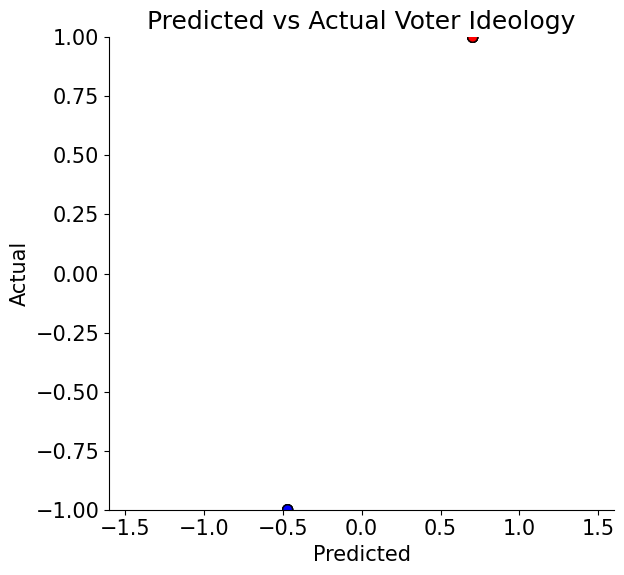

In [13]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from scipy.stats import spearmanr

# Setup
cmap = mcolors.LinearSegmentedColormap.from_list("red_white_blue", ["blue", "white", "red"])
model_name = 'meta-llama/Llama-2-7b-chat-hf'
k = 4

# Load data
features_voters, labels_voters = pickle.load(open(f"./results_replication/{model_name.replace('/','_')}_voter_features.pkl", 'rb'))
features_politicians, labels_politicians = pickle.load(open(f"./results_replication/{model_name.replace('/','_')}_politician_features.pkl", 'rb'))
performance = pickle.load(open(f"./results_replication/{model_name.replace('/','_')}_politician_performance.pkl", 'rb'))

# Top-k (i, j) heads
top_indices = np.dstack(np.unravel_index(np.argsort(performance.ravel()), (32, 32)))[0][-k:, :]

# Ensemble prediction over voter samples
kf = KFold(n_splits=2, shuffle=True, random_state=42)
ensemble_pred = np.zeros(labels_voters.shape)

for train_indices, test_indices in kf.split(range(features_politicians.shape[0])):
    for i, j in top_indices:
        X_train = features_politicians[train_indices, 0, i, j, :]
        X_test = features_politicians[test_indices, 0, i, j, :]
        y_train = np.array(labels_politicians)[train_indices]
        y_test = np.array(labels_politicians)[test_indices]
        
        ridge_model = Ridge(alpha=1, fit_intercept=False)
        ridge_model.fit(X_train, y_train)
        
        y_pred = ridge_model.predict(features_voters[:, 0, i, j, :])
        ensemble_pred += y_pred

ensemble_pred = ensemble_pred / k / 2
print(model_name, k, spearmanr(labels_voters, ensemble_pred).statistic)
print(labels_voters, ensemble_pred)

# Plotting
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(6.5, 6))
plt.grid(False)
plt.title("Predicted vs Actual Voter Ideology")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.scatter(ensemble_pred, labels_voters, c=ensemble_pred, cmap=cmap, alpha=0.8, s=50, edgecolor='black')
plt.xlim(-1.6, 1.6)
plt.ylim(-1, 1)
plt.yticks(np.arange(-1, 1.25, 0.25))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('llama2_voters.pdf')


In [69]:
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = 'meta-llama/Llama-2-7b-chat-hf'  # ← change this as needed
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load model & tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir='./model', token=HUGGINGFACE_TOKEN)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    cache_dir='./model',
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
    low_cpu_mem_usage=True,
    token=HUGGINGFACE_TOKEN
).to(device).eval()

# Load question data
df = pd.read_csv("data_replication/anes.csv")

# Generate and print answers
for _, row in df.iterrows():
    domain, query = row['domain'], row['query']
    print(f"\n🧭 Domain: {domain}")

    for alignment in ['liberal', 'conservative']:
        prompt = build_prompt(alignment, query)
        inputs = tokenizer(prompt, return_tensors='pt').to(device)

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=30,
                do_sample=False,
                pad_token_id=tokenizer.eos_token_id
            )
        decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
        answer = decoded.replace(prompt, '').strip()
        print(f"  [{alignment.title()}] → {answer}")

del model
gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]


🧭 Domain: Abortion
  [Liberal] → abortion should be legal in most cases, with 62% of them supporting the statement "Abortion should be legal in most cases,
  [Conservative] → abortion should be illegal in most cases, with a scale rating of 5. However, it's important to note that opinions on this matter

🧭 Domain: Border Wall
  [Liberal] → building a wall on the U.S. border with Mexico was not a viable or effective solution to address the complex issues surrounding immigration. Many
  [Conservative] → building a wall on the U.S. border with Mexico was a necessary measure to secure the country's borders and prevent illegal immigration. However

🧭 Domain: Transgender Bathroom
  [Liberal] → transgender people should be allowed to use public bathrooms matching their gender identity. According to a survey conducted by the Pew Research Center, 7
  [Conservative] → allowing transgender people to use public bathrooms matching their gender identity was a controversial issue. While some conserva

## Probing

In [ ]:
for model_name in ['meta-llama/Llama-2-7b-chat-hf', 'mistralai/Mistral-7B-Instruct-v0.1', 'lmsys/vicuna-7b-v1.5']:
    features, labels = pickle.load(open(f"./results_replication/{model_name.replace('/','_')}_politician_features.pkl", 'rb'))
    performance = np.zeros((model.config.num_hidden_layers, model.config.num_attention_heads))
    ridge_dict = {}
    for i in tqdm(range(model.config.num_hidden_layers)):
        ridge_dict[i] = {}
        for j in range(model.config.num_attention_heads):
            kf = KFold(n_splits=2, shuffle=True, random_state=42)
            for train_indices, test_indices in kf.split(range(features.shape[0])):
                X_train = features[train_indices, 0, i, j, :]
                X_test = features[test_indices, 0, i, j, :]
                y_train = np.array(labels)[train_indices]
                y_test = np.array(labels)[test_indices]
                ridge_model = Ridge(alpha=1, fit_intercept=False)
                ridge_model.fit(X_train, y_train)
                ridge_dict[i][j] = ridge_model
                y_pred = ridge_model.predict(X_test)
                performance[i, j] += spearmanr(y_test, y_pred).statistic
    performance /= 2
    pickle.dump(performance, open(f"./results_replication/{model_name.replace('/','_')}_politician_performance.pkl", 'wb'))
    pickle.dump(ridge_dict, open(f"./results_replication/{model_name.replace('/','_')}_ridge.pkl", 'wb'))

# Intervention

In [ ]:
def lt_modulated_vector_add(head_output, layer_name):
    layer_index = layer_name[len('model.layers.'):]
    layer_index = int(layer_index[:layer_index.index('.')])
    head_output = rearrange(head_output.detach().cpu(), 'b s (h d) -> b s h d', h=model.config.num_attention_heads)
    for head_index in head_dict[layer_index]:
        head_output[:, -1, head_index, :] += alpha  * focal_ridge_dict[(layer_index, head_index)] * np.std(features[:, 0, layer_index, head_index, :], axis=0)
    head_output = rearrange(head_output, 'b s h d -> b s (h d)')
    return head_output.to('cuda')

for model_name in ['meta-llama/Llama-2-7b-chat-hf', 'mistralai/Mistral-7B-Instruct-v0.1', 'lmsys/vicuna-7b-v1.5']:
    tokenizer = llama.LlamaTokenizer.from_pretrained(model_name, cache_dir='./model', token=HUGGINGFACE_TOKEN)
    model = llama.LlamaForCausalLM.from_pretrained(model_name, cache_dir='./model', low_cpu_mem_usage=True, torch_dtype=torch.float16, 
                                                   token=HUGGINGFACE_TOKEN).to('cuda:0')
    performance = pickle.load(open(f"./results_replication/{model_name.replace('/','_')}_politician_performance.pkl", 'rb'))
    features, labels = pickle.load(open(f"./results_replication/{model_name.replace('/','_')}_politician_features.pkl", 'rb'))
    trained_ridge_dict = pickle.load(open(f"./results_replication/{model_name.replace('/','_')}_ridge.pkl", 'rb'))
    topics = ['abortion', 'immigration', 'gun control', 'same-sex marriage', 'LGBTQ+ rights', 
              'climate change', 'trust in science', 'social media regulation', 'free speech']
    results = []
    for k in reversed([16, 32, 48, 64, 80, 96]):
        for alpha in tqdm(reversed([-30, -20, -10, 0, 10, 20, 30])): # Add -50, -40, 40, 50 for the coherence tests
            for topic in topics:
                print(k, alpha, topic)
                original_prompt = f"Write a statement about {topic}."
                top_indices = np.dstack(np.unravel_index(np.argsort(performance.ravel()), (32, 32)))[0][-k:, :][::-1]
                focal_ridge_dict = {}
                for i in top_indices:
                    ridge_model = trained_ridge_dict[i[0]][i[1]]
                    focal_ridge_dict[tuple(i)] = ridge_model.coef_
                head_dict = {}
                for i in top_indices:
                    if i[0] not in head_dict:
                        head_dict[i[0]] = [i[1]]
                    else:
                        head_dict[i[0]].append(i[1])
                with TraceDict(model, [f'model.layers.{i}.self_attn.head_out' for i in sorted(list(set(top_indices[:,0])))], edit_output=lt_modulated_vector_add) as ret: 
                    input_ids = tokenizer(f"USER: {original_prompt}\nASSISTANT: Regarding {topic}, I believe that ", return_tensors="pt")['input_ids']
                    model_gen_tokens = model.generate(input_ids.to('cuda')[0][:-1].unsqueeze(0), max_length=200)
                model_gen_str = tokenizer.decode(model_gen_tokens[0], skip_special_tokens=True)
                model_gen_str = model_gen_str.strip()
                results.append([k, alpha, topic, model_gen_str])
    pickle.dump(results, open(f"./results_replication/{model_name.replace('/','_')}_intervention_results.pkl", 'wb'))

In [ ]:
results = []
for model_name in ['meta-llama/Llama-2-7b-chat-hf', 'mistralai/Mistral-7B-Instruct-v0.1', 'lmsys/vicuna-7b-v1.5']:
    results += pickle.load(open(f"./results_replication/{model_name.replace('/','_')}_intervention_results.pkl", 'rb'))

pd.DataFrame(results).to_parquet('intervention_raw.parquet')